# Run motion analyses on ADHD data

In [1]:
%matplotlib inline
import pandas as pd
from nilearn import datasets

from ddmra import run_analyses, utils

/opt/miniconda3/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
%%time
# Constants
n_subjects = 31
qc_thresh = 0.2
data = datasets.fetch_adhd(n_subjects=n_subjects)
n_iters = 100

# Prepare data
imgs = []
fd_all = []
for i in range(n_subjects):
    func = data.func[i]
    imgs.append(func)
    conf = data.confounds[i]
    df = pd.read_table(conf)
    motion = df[['motion-pitch', 'motion-roll', 'motion-yaw',
                 'motion-x', 'motion-y', 'motion-z']].values
    fd_all.append(utils.get_fd_power(
        motion, order=['p', 'r', 'ya', 'x', 'y', 'z'], unit='deg'))

/opt/miniconda3/lib/python3.8/site-packages/nilearn/datasets/func.py:250: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  phenotypic = np.genfromtxt(phenotypic, names=True, delimiter=',',


CPU times: user 96.7 ms, sys: 19.2 ms, total: 116 ms
Wall time: 119 ms


/opt/miniconda3/lib/python3.8/site-packages/nilearn/datasets/atlas.py:790: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
Scrubbing null distribution: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


CPU times: user 9min 44s, sys: 1min 23s, total: 11min 8s
Wall time: 5min 3s


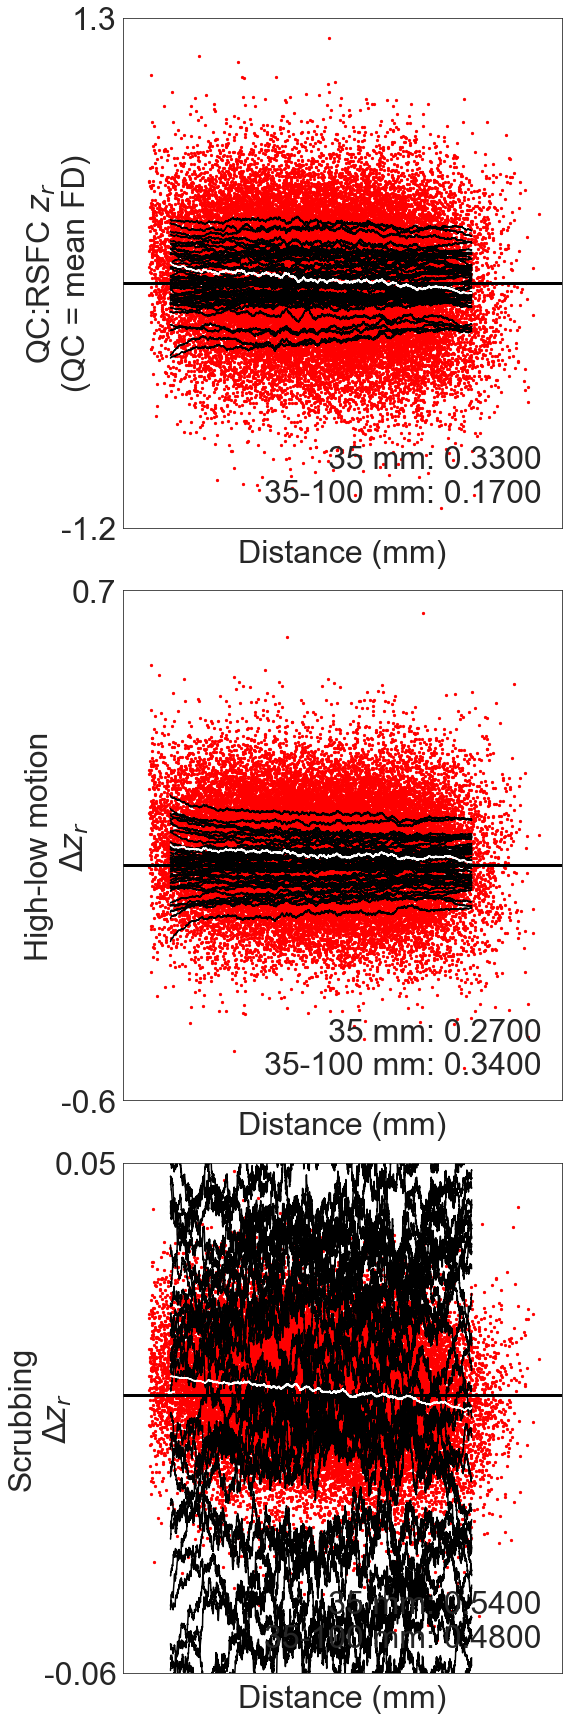

In [3]:
%%time
run_analyses(imgs, fd_all, out_dir='results/', n_iters=n_iters, n_jobs=2, qc_thresh=qc_thresh)

In [4]:
ranks_df = pd.read_table("results/rank_smoothing_curves.tsv.gz")
ranks_df

,distance,qcrsfc,highlow,scrubbing
0,19.313,59.732000,59.037000,62.38500
1,19.339,59.639500,58.996750,62.35525
2,19.391,59.530000,58.901000,62.40550
3,19.416,59.505000,58.877500,62.48500
4,19.442,59.363571,58.793857,62.42100
...,...,...,...,...
11905,142.955,45.058000,50.307000,42.03600
11906,142.972,45.008000,50.212000,42.07900
11907,142.976,44.979000,50.159000,42.10100
11908,143.010,45.008000,50.182000,42.18800


<ipython-input-5-ba8cca53100e>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


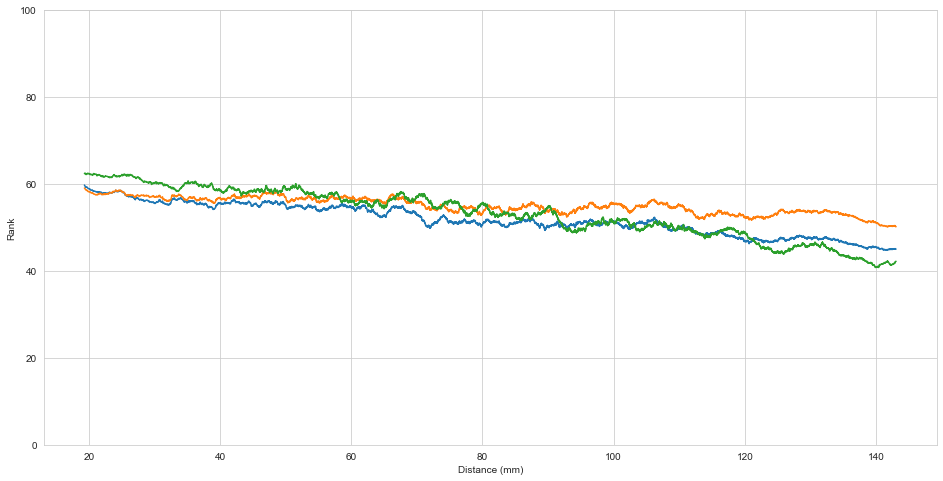

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


def rankbased_p(rank, n_iters):
    p_value = 1 - (rank / n_iters)
    return p_value

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(ranks_df["distance"], ranks_df[["qcrsfc", "highlow", "scrubbing"]])
ax.set_ylim(0, 100)
ax.set_xlabel("Distance (mm)")
ax.set_ylabel("Rank")
fig.show()